# DAPyr Tutorial

DAPyr ((D)ata (A)ssimilation (Py)thon (r)elease) is an data assimilation python implementation. This module serves to provide a basic environment to learn and test data assimilation methods, as well as a basis for developing further data assimilation methods in a toy environment.

The following notebook will go through the basic structure of the package, as well as provide examples.

## Introduction

First, we must import our module, DAPyr, as well as numpy and matplotlib for additional array manipulation and plotting later on. DAPyr requires the following packages to function:

* Numpy
* Matplotlib
* Scipy
* Numba
* Xarray
* Numbalsoda

If you are using a package manager like conda, these can all be installed using the default and conda-forge channels. 

In [1]:
import DAPyr as dap
import numpy as np
import matplotlib.pyplot as plt

There are two main pieces of the `DAPyr` module. The `Expt()` class and the `runDA` function. 

The `Expt` sets up the experiment you want to run. Through this class, you can configure things like the type of model you wish to run, how long to run it for, and what data assimilation method to use. 

The `Expt` class takes in a string for the name of the experiment, and an optional `params` dictionary containing any settings you with to change. Initializing an experiment without providing a `params` dictionary sets all configurable variables to their default values.

Below, we will create an experiment call "Basic_Expt". We will run a 20 member ensemble 200 time steps using Lorenz 96 as our toy model.

In [7]:
expt  = dap.Expt('Basic_Expt', {'expt_flag': 0, "Ne": 20, 'model_flag':1, 'T': 200, 'saveEns': 1, 'saveEnsMean': 1, 'seed': 1})

If you need a reminder of what settings an experiment has configured, simply print the experiment out.

In [5]:
print(expt)


            ------------------
            Basic Information
            ------------------
            Experiment Name: Basic_Expt
            Ne: 20 # Number of Ensemble Members
            T: 200 # Number of Time Periods
            dt: 0.05 # Width of Timesteps
            seed: 1 # Sets a seed for the random number generator, set to -1 to turn off

            ------------------
            Model Information
            ------------------
            model_flag: 1 # Model used in forward integration
                  0: Lorenz 1963 (Nx = 3)
                  1: Lorenz 1996 (Nx = 40)
                  2: Lorenz 2005 (Nx  = 480)
            Nx: 40 # The number of state variables
            
            params: {'s': 10, 'r': 28, 'b': 2.6666666666666665, 'F': 8, 'l05_F': 15, 'l05_Fe': 15, 'l05_K': 32, 'l05_I': 12, 'l05_b': 10.0, 'l05_c': 2.5} # Parameters to tune each forecast model
            Above is a list of all the parameters stored for use in the forecast model
             

To get the results of a single parameter in the experiment use the `Expt.getParam()` method to retrieve it. 

In [5]:
print('Getting the model_flag used')
expt.getParam('model_flag')

Getting the model_flag used


1

To change a parameter in the experimental setup, use the `Expt.modExpt()` method. 

NOTE: Modifying certain parameters in your experiment (such as the number of ensemble members (Ne) or number of model time steps (T)) will force the experiment to rerun spin-up, meaning that you will have new *model truth values, observations, and ensemble states*. Certain few parameters (such as the DA method to use (expt_flag)) will not change the experimental initial states.

In [8]:
#Lets change the DA method from EnSRF to LPF
print('This is the first observation before experiment modification: {}'.format(expt.getParam('Y')[0, 0, 0]))
#Now let's modify the experiment
expt.modExpt({'expt_flag': 1})
print('Note the observation is the same after modification: {}'.format(expt.getParam('Y')[0, 0, 0]))
#Now let's modify something that will change the state, such as the observation error
expt.modExpt({'sig_y': 1.5})
print('Note the observation is different after modification: {}'.format(expt.getParam('Y')[0, 0, 0]))

This is the first observation before experiment modification: -1.5107367287379363
Note the observation is the same after modification: -1.5107367287379363
Note the observation is different after modification: -1.1035651641634736


Once you are happy with your experiment, it is time to run the actual data assimilation cycles. To do this, use the `DAPyr.runDA()` function. It simply takes in an `Expt` instance, and runs through all specifications of the experiment.

In [12]:
# Lets run our basic experiment, after running, it should print a "completed" message
dap.runDA(expt)

'completed'

From here, there are a number of outputs you can reference.

* `Expt.rmse`: The posterior RMSE over the experiment 
* `Expt.prior_rmse`: The prior RMSE over the experiment 
* `Expt.spread`: A (T x 2) matrix where [:, 0] are the prior ensemble spreads, and [:, 1] are the posterior ensemble spreads
* `Expt.x_ens`: If "saveEns" is set to 1 in configuration, the full posterior ensemble states are stored 
* `Expt.x_ensmean`: If "saveEnsMean" is set to 1 in configuration, the full posterior ensemble means are stored
* `Expt.x_fore_ens`: If "saveForecastEns" is set to 1 in configuration, the full prior ensemble states are stored

Text(0, 0.5, 'Posterior RMSE')

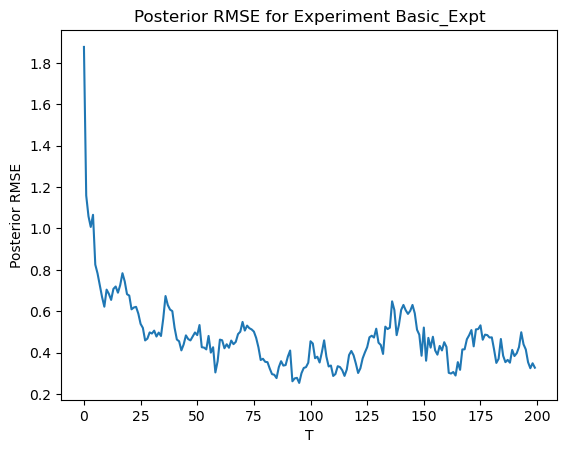

In [8]:
plt.plot(expt.rmse)
plt.title('Posterior RMSE for Experiment {}'.format(expt.exptname))
plt.xlabel('T')
plt.ylabel('Posterior RMSE')

## Plotting

There are a number of functions you can use to visualize your experiments. An often-hard-to-understand parameter is localization, or the degree which observations effect points spatially. To help visualize this parameter, use the `plotLocalization` function. Let's take our previous experiment, adjust the localization, and plot them side by side.

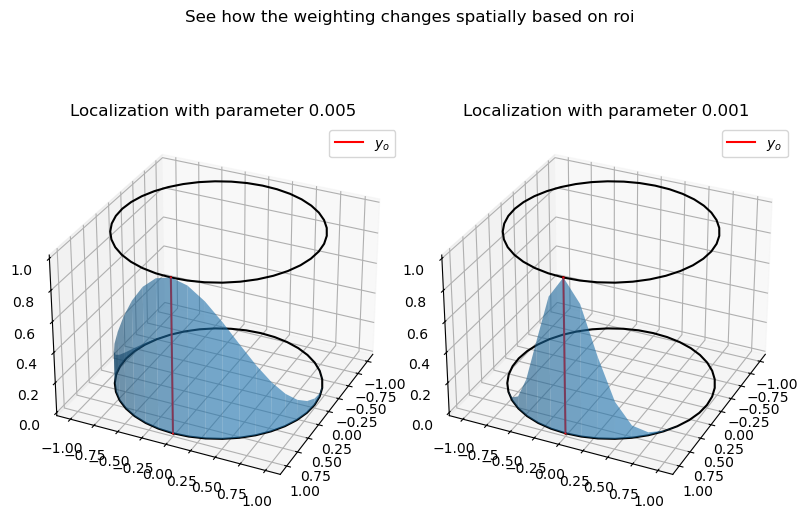

In [9]:
expt2 = dap.copyExpt(expt)
expt2.modExpt({'roi': 0.001})
fig, ax = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize = (8, 6))
dap.plotLocalization(expt, ax[0])
dap.plotLocalization(expt2, ax[1])
ax[0].set_title('Localization with parameter {}'.format(expt.getParam('roi')))
ax[1].set_title('Localization with parameter {}'.format(expt2.getParam('roi')))
fig.suptitle('See how the weighting changes spatially based on roi')
fig.tight_layout()

After you've run your experiment, you can visualize each point of the experiment, provided you've stored intermediate values. Use the `plotExpt` function to visualize how ensemble members vary compared to the model truth. Here, model truth is plotted in blue and ensemble members are plotted in grey.

<Axes3D: >

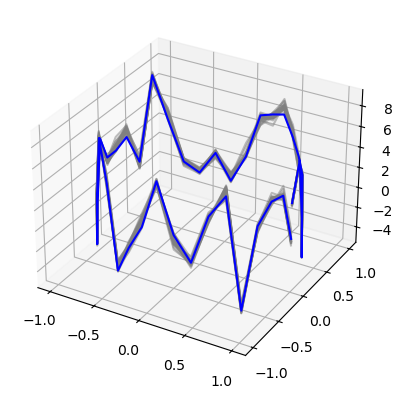

In [13]:
dap.plotExpt(expt, T = 10)

Plot observations and the ensemble mean simply by setting `plotObs` and `plotEnsMean` to `True`. You can also pass a matplotlib `Axes` object in to plot onto. Note how well the ensemble members converge onto model truth by the 100th time step.

Text(0.5, 0.92, 'State at T = 100')

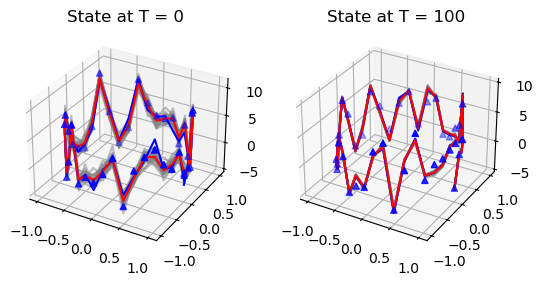

In [14]:
plt.close()
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': '3d'})
dap.plotExpt(expt, 0, axes[0], plotEnsMean=True, plotObs=True)
dap.plotExpt(expt, 100, axes[1], plotEnsMean=True, plotObs=True)
axes[0].set_title('State at T = 0')
axes[1].set_title('State at T = 100')
